# NammaMetro Ridership EDA

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Let's take a closer look at what NammaMetro has been dishing out so far

In [10]:
filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename, index_col=0)
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y').dt.strftime("%Y-%m-%d")
df.tail(10)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
7,2024-11-03,131411,130715,595,61,40,248051,3174,283,153605,41775,84027,27803.0
8,2024-11-05,456576,455981,387,26,182,197699,11202,338,173838,49700,90298,33840.0
9,2024-11-06,464487,463757,457,59,214,201316,11459,224,169298,48994,86194,34110.0
10,2024-11-09,324351,323395,769,81,106,242952,3145,477,177960,48606,96889,32465.0
11,2024-11-10,175159,173852,1152,84,71,262652,4351,805,211556,58182,115169,38205.0
12,2024-11-11,464358,463652,428,67,211,218340,11685,964,182878,52281,95194,35403.0
13,2024-11-12,475075,474261,499,74,241,193049,12160,605,175699,49885,90758,35056.0
14,2024-11-13,472363,471546,501,73,243,204021,12056,1090,177117,50163,91783,35171.0
15,2024-11-14,471099,469989,787,86,237,207693,11858,348,180760,50740,93169,36851.0
16,2024-11-15,444111,443160,668,85,198,211495,10644,413,180093,51089,94929,34075.0


### Note the gaps in the data. 
NammaMetro fails to report ridership numbers on some days. Is someone updating the page manually?! 

   Record Date  Total Riders
0   2024-10-26        780578
1   2024-10-27        637048
2   2024-10-28        849136
3   2024-10-29        851285
4   2024-10-30        870881
5   2024-11-01        404342
6   2024-11-02        480284
7   2024-11-03        536524
8   2024-11-05        839653
9   2024-11-06        846784
10  2024-11-09        748885
11  2024-11-10        654523
12  2024-11-11        878225
13  2024-11-12        856588
14  2024-11-13        866647
15  2024-11-14        871758
16  2024-11-15        846756


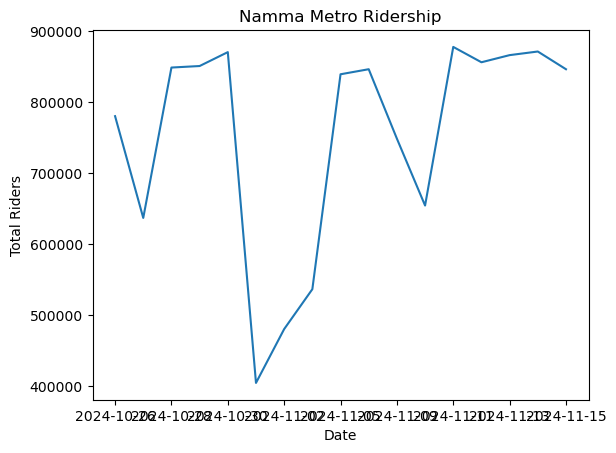

In [11]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 'Tokens', 'Total NCMC', 'Group Ticket', 'Total QR']].sum(axis=1)
table = df[['Record Date', 'Total Riders']]
print(table)
table.plot(x='Record Date', 
           y='Total Riders', 
           kind='line', 
           title='Namma Metro Ridership', 
           xlabel='Date', 
           ylabel='Total Riders', 
           legend=False)
plt.show()

### Let's make a cleaner graph for the last 10 days of available data.

    Day of Month  Total Riders
7              3        536524
8              5        839653
9              6        846784
10             9        748885
11            10        654523
12            11        878225
13            12        856588
14            13        866647
15            14        871758
16            15        846756


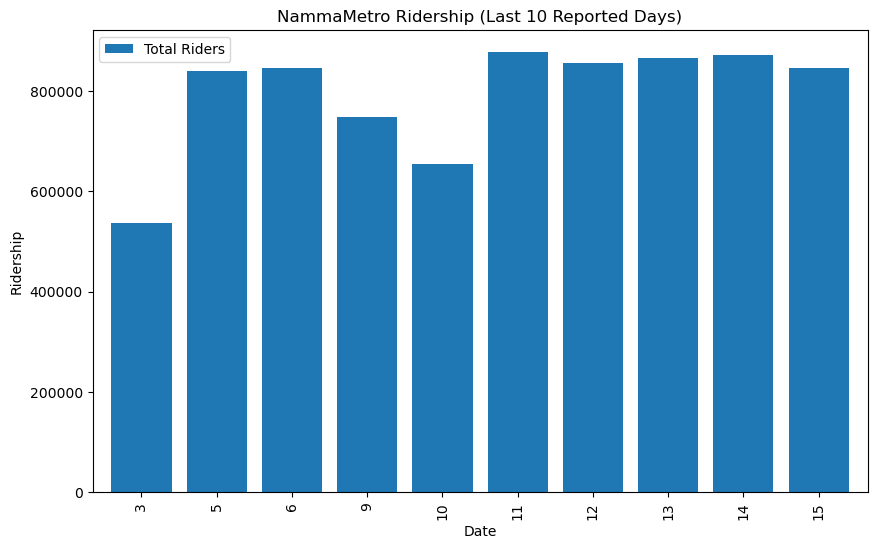

In [12]:
df['Day of Month'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d').dt.day
table = df[['Day of Month', 'Total Riders']].tail(10)
print(table)
table.plot(x='Day of Month', 
           y='Total Riders', 
           kind='bar', 
           xlabel='Date', 
           ylabel='Ridership', 
           title='NammaMetro Ridership (Last 10 Reported Days)', 
           figsize=(10,6), 
           width=0.8,
           legend=True)
plt.show()

### Let's get a better understanding of that missing data.

In [13]:
# Generate a dataframe with last n sequential dates

from datetime import date, timedelta
number_of_days = 14
start_date = date.today() - timedelta(number_of_days, 0, 0)
dates_table = pd.DataFrame({'Record Date': [str(start_date+timedelta(n)) for n in range(number_of_days)]})

In [14]:
# Merge the original df with the column of dates to get all values including nulls

last_N_days = df.merge(dates_table, how='right', on='Record Date')
last_N_days['Day of Month'] = pd.to_datetime(last_N_days['Record Date'], format='%Y-%m-%d').dt.day
last_N_days.drop(['Stored Value Card', 'One Day Pass', 'Five Day Pass', 'Three Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
last_N_days['Total Riders'] = last_N_days[['Total Smart Cards', 'Tokens', 'Total NCMC', 'Group Ticket', 'Total QR']].sum(axis=1).astype(int)
last_N_days = last_N_days[['Record Date', 'Day of Month', 'Total Riders']]
print(last_N_days)

   Record Date  Day of Month  Total Riders
0   2024-11-02             2        480284
1   2024-11-03             3        536524
2   2024-11-04             4             0
3   2024-11-05             5        839653
4   2024-11-06             6        846784
5   2024-11-07             7             0
6   2024-11-08             8             0
7   2024-11-09             9        748885
8   2024-11-10            10        654523
9   2024-11-11            11        878225
10  2024-11-12            12        856588
11  2024-11-13            13        866647
12  2024-11-14            14        871758
13  2024-11-15            15        846756


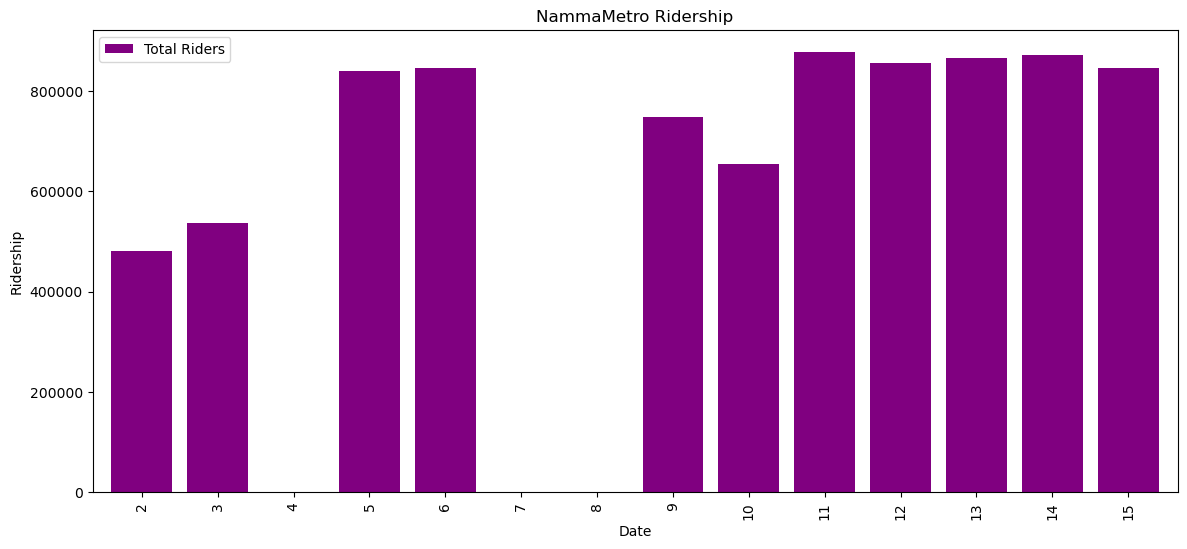

In [15]:
last_N_days.plot(x='Day of Month', 
                 y='Total Riders', 
                 kind='bar', 
                 xlabel='Date', 
                 ylabel='Ridership', 
                 title='NammaMetro Ridership', 
                 figsize=(14,6), 
                 width=0.8,
                 color='purple',
                 legend=True)
plt.show()

### Looks like a mouth with quite a few broken teeth!

### What sort of data imputations makes sense here? When the dataset grows large enough over several months, I would fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4 available weekday Tuesdays.